# Lab 2: GPs for Non-Gaussian Likelihoods and Big Data
### Gaussian Process Summer School 2020
This lab introduces Gaussian process regression for data with non-Gaussian likelihoods, and shows how this can be applied to classification. The concept of sparse methods for Gaussian process regression is introduced for creating a scalable regression model, and this is combined with a large classification problem.

As with Lab 1, the notebook uses `GPy` for handling the regression model and likelihoods.

##  1. Getting started

First we setup our notebook with the libraries we are going to use. As with Lab 1, we use `numpy` for maths functionality, `pyplot` for plotting, and `GPy` for Gaussian processes.

In [1]:
# Support for maths
import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# GPy: Gaussian processes library
import GPy

The documentation for `GPy` is available at [gpy.readthedocs.io](http://gpy.readthedocs.io/en/deploy/). We will be using GPy to define our kernels, and regression. Note that `GPy` also contains plotting utilities, but we will not use these in this lab.

We will recycle our GP plotting utility from Lab 1:

In [2]:
def plot_gp(X, m, C, training_points=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    # Plot 95% confidence interval 
    plt.fill_between(X[:,0],
                     m[:,0] - 1.96*np.sqrt(np.diag(C)), # 95% confidence interval of a Gaussian is
                     m[:,0] + 1.96*np.sqrt(np.diag(C)), # .. contained within mean +/- 1.96*s.d.
                     alpha=0.5)
    # Plot GP mean and initial training points
    plt.plot(X, m, "-")
    plt.legend(labels=["GP fit"])
    
    plt.xlabel("x"), plt.ylabel("f")
    
    # Plot training points if included
    if training_points is not None:
        X_, Y_ = training_points
        plt.plot(X_, Y_, "kx", mew=2)
        plt.legend(labels=["GP fit", "sample points"])

---
## 2. Non-Gaussian likelihoods

Consider the regression model:

$$
    \mathbf{y} \sim \pi(\mathbf{X}, \varphi),
$$
where $\mathbf{y}$ are some observations given input $\mathbf{X}$ distributed by some likelihood function with parameters $\varphi$.

In yesterday's lab, we looked at regression models with Gaussian process priors and Gaussian likelihoods:

$$
    \mathbf{y} \sim \mathcal{N}(f(\mathbf{X}), \sigma^2) \qquad \text{which can equivalently be written} \qquad \frac{1}{\sigma}(\mathbf{y} - f(\mathbf{X})) \sim \mathcal{N}(0, 1)
$$

We assume $f \sim \mathcal{GP}(m(\cdot), k(\cdot,\cdot))$ and $\sigma^2$ is the variance of some additive observation noise $\epsilon \sim \mathcal{N}(0, \sigma^2)$. However, often this is not the best way to model a problem, for example in observation models with outliers, or classification problems. For this, we have to make approximations of the likelihood to fit into the GP regression model.

Consider the Olympic men's marathon data, which we will load from a local directory [[full download here]](https://github.com/gpschools/labs/raw/master/.resources/olympic_marathon_men):

In [3]:
import pickle

with open("../.resources/olympic_marathon_men", "rb") as fid:
    data = pickle.load(fid)

print("\nData keys:")
print(data.keys())

print("\nCitation:")
print(data['citation'])

print("\nInfo:")
print(data['details'])


Data keys:
dict_keys(['X', 'Y', 'citation', 'details', 'files', 'license', 'size', 'urls'])

Citation:
None

Info:
Olympic mens' marathon gold medal winning times from 1896 to 2012. Time given in pace (minutes per kilometer). Data is originally downloaded and collated from Wikipedia, we are not responsible for errors in the data


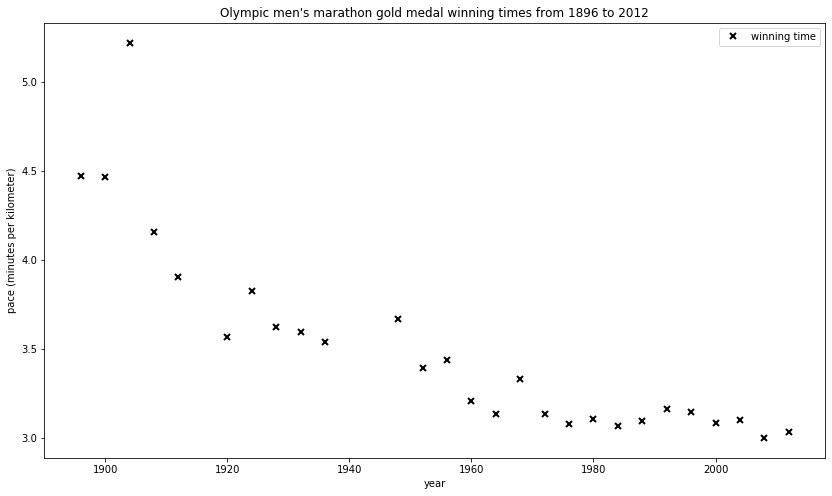

In [4]:
# Training data (X = input, Y = observation)
X, y = data['X'], data['Y']

# Set up our plotting environment
plt.figure(figsize=(14, 8))

# Plot the training data, the results of the gold medal winning time for the Olympic men's marathon
plt.plot(X, y, "kx", mew=2)

# Annotate plot
plt.legend(labels=["winning time"]), plt.xlim((1890, 2018))
plt.xlabel("year"), plt.ylabel("pace (minutes per kilometer)")
plt.title("Olympic men's marathon gold medal winning times from 1896 to 2012");

Notice that there is what looks like an outlier in 1904, which may make it difficult to fit a Gaussian likelhood to the data.

We will attempt to fit a Gaussian process regression model using a Gaussian likelihood. This is equivalent to the regressions we were performing yesterday, which assumed that we could perform exact Gaussian inference due to Gaussian likelihood. The model we used in `GPy` had all of these presets assumed: `models.GPRegression()`, however we will manually set the inference method and likelhood using the `core.GP()` class, which gives us more flexibility for customisation.

The likelihood functions can be found in `GPy.likelihoods`, and we will use `likelihoods.Gaussian()` here, with the variance set to $1.0$. The inference methods for a GP can be found in `GPy.inference.latent_function_inference`, from which we will use `ExactGaussianInference()`, which exploit the properties of tractability we gain from having Gaussian assumptions.

In [5]:
k = GPy.kern.RBF(1, name="rbf")

# The below GP setup is equivalent to
#   m = GPy.models.GPRegression(X, y, k)
# which sets the inference and likelihood to be exact Gaussian inference by default

m = GPy.core.GP( # Note that we are using the core GP model here, which allows us 
    X, y,        # .. to tailor the inference and likelihood later
    kernel = k,  # ... for now we replicate the defaults
    inference_method = GPy.inference.latent_function_inference.ExactGaussianInference(),# Exact Gaussian inference
    likelihood = GPy.likelihoods.Gaussian(variance=1.) # Gaussian likelihood
)
m.optimize()

m

gp.,value,constraints,priors
rbf.variance,25.399458856653396,+ve,
rbf.lengthscale,152.0451327599257,+ve,
Gaussian_noise.variance,0.04850644102720907,+ve,


We predict the race pace defined by the latent function for every year. We will plot the latent function only by not including the likelihood in our prediction. This is equivalent to using `m.predict_noiseless()`, because our likelihood here is latent function augmented with the (zero-mean) Gaussian noise attributed to the measurements. You could try including the likelihood, and see how it incorporates the uncertainty by increasing the confidence intervals about the mean.

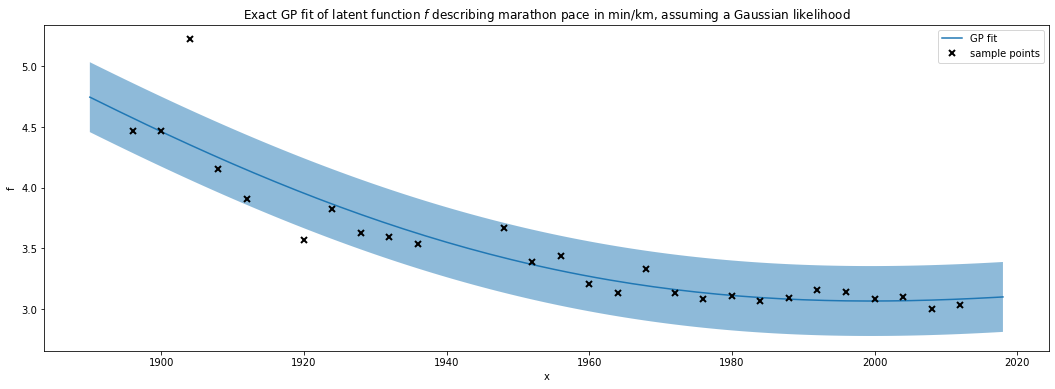

In [6]:
Xnew = np.arange(1890,2019)[:, None] # predict winning pace every year between 1890 and 2018

mean, Cov = m.predict(Xnew, include_likelihood=False)

plt.figure(figsize=(18,6))
# Plot the GP prediction of the latent function with training points
plot_gp(Xnew, mean, Cov, training_points=(X,y))
# Annotate plot
plt.title("Exact GP fit of latent function $f$ describing marathon pace in min/km, assuming a Gaussian likelihood");

While this may seem like an adequate fit, it can be observed that the outlier at 1904 is affecting the mean estimate, as it appears consistently higher than observed measurements for the next three decades. This is due to the Gaussian likelihood assumption means that the regression is heavily affected by the outliers. 

We could alternatively use a heavy tailed [Student's $t$-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) which can reduce the influence of outliers in the inference. Consider the regression model$^\ast$:
$$
    \frac{1}{\sigma^2}(\mathbf{y} - f(\mathbf{X})) \sim \mathcal{T}(\nu)
$$

However, we cannot trivially extend the Gaussian process updates to find the posterior, so some approximation method needs to be used. We will use Laplace's method for approximating the posterior integrals with a Gaussian distribution using second order Taylor expansions. `GPy` contains the utility to include a Laplace approximation in our `GP`.

$^\ast$_note that we write the regression model like this because Student's $t$-distribution is defined with zero mean, and controlled by $\nu$, the degrees of freedom, only. However, we include a scaling parameter, $\sigma^2$ that is equivalent to the variance in our likelihood model (see the Gaussian likelihood example above)_

In [7]:
Xnew = np.arange(1890,2019)[:, None] # predict winning pace every year between 1890 and 2018

# We define a Student's t distribution with default nu=5.0 and sigma^2=2.0
# ... nu describes the degrees of freedom
t_dist  = GPy.likelihoods.StudentT(deg_free=5., sigma2=2.)

# We will use the same kernel, an RBF do desribe the trend and a Bias term to offset the fit
k = GPy.kern.RBF(1, lengthscale=5.) + GPy.kern.Bias(1, variance=4.)

# We fit the model as before, but customise the likelihood (with the t-distribution),
# .. and approximate inference method, here using Laplace

m = GPy.core.GP( # Note that we are using the core GP model here, which allows us 
    X, y,        # .. to tailor the inference and likelihood, instead of the default
    kernel = k,  #  .. GP regression model used previously
    inference_method = GPy.inference.latent_function_inference.Laplace(), # Laplace approximation for inference
    likelihood = t_dist # Our Student's t-distribution with initial parameters defined above
)

# Optimise the kernel and likelihood parameters
m.optimize()

# Preview our model
m

gp.,value,constraints,priors
sum.rbf.variance,0.31992617301609255,+ve,
sum.rbf.lengthscale,23.232527523507,+ve,
sum.bias.variance,5.871676625045135,+ve,
Student_T.t_scale2,0.00579242124546821,+ve,
Student_T.deg_free,1.7650167149296074,+ve,


Notice that in our list of parameters, we no longer have `Gaussian_noise.variance`, which was the parameter of the Gaussian likelihood, and instead have `Student_T.t_scale2` and `Student_T.deg_free` which correspond respectively to the scale (equivalent to variance), and degrees of freedom that describe our Student's $t$-distribution.

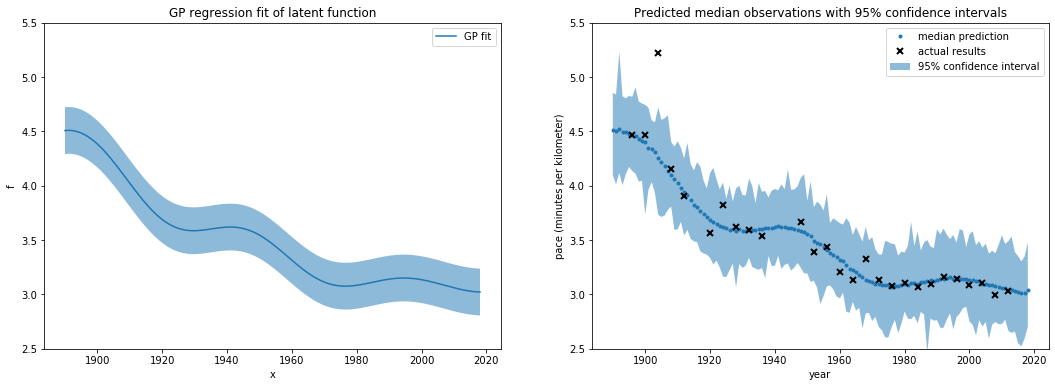

In [8]:
# We plot the latent function without the likelhood
#   This is equivalent to predict_noiseless in the previous lab
mean, Cov = m.predict(Xnew, include_likelihood=False)

# We will also predict the median and 95% confidence intervals of the likelihood
quantiles = m.predict_quantiles(Xnew, quantiles=(2.5, 50., 97.5), likelihood=m.likelihood)

# Prepare figure environment
plt.figure(figsize=(18,6))

plt.subplot(121)
# Plot the GP fit of our latent function f(X)
plot_gp(Xnew, mean, Cov)

# Annotate plot
plt.ylim((2.5, 5.5))
plt.title("GP regression fit of latent function")


plt.subplot(122)
# Plot the median of the predicted likelihood
plt.plot(Xnew, quantiles[1], ".")
# Add a confidence interval between the 2.5 and 97.5 quantiles (95% of predicted data)
plt.fill_between(Xnew[:,0], quantiles[0][:,0], quantiles[2][:,0], alpha=0.5)
# Plot observations
plt.plot(X, y, "kx", mew=2)

# Annotate plot
plt.xlabel("year"), plt.ylabel("pace (minutes per kilometer)"), plt.ylim((2.5, 5.5))
plt.title("Predicted median observations with 95% confidence intervals");
plt.legend(labels=["median prediction", "actual results", "95% confidence interval"]);

When building our confidence intervals in the likelihood, we can no longer rely on the properties of the Gaussian that allow us to build our intervals as a proportion of the standard deviation. Instead, we must obtain the quantiles from the inverse cumulative density function. To obtain the confidence interval, containing 95% of samples from our fit, we must evaluate our inverse CDF at 0.025 and 0.975 (e.g. 2.5% and 97.5% respectively). We also plot the median (i.e. the 50% quantile). `GPy` allows us to obtain the quantiles of the prediction likelihood directly, using `predict_quantiles()`.

We could also also obtain the variance (in the usual way) and plot it as an alternative representation of the uncertainty in our fit.

### Exercise 1

Comment on the fit using the Student's $t$-distribution. Can you make a reasonable prediction (with confidence intervals) for the gold medal time in the 2016 Olympics? How does it compare to the true value ($2016, 3.05$). What about predictions for the next 3 Olympics?

> The Student's t-distribution has drastically reduced the effects of the outlier in 1904, giving tighter bounds and a mean function that fits the rest of the data well. The prediction noise is less smooth than with Gaussian likelihood, but the predictions are realistic and ignore the outlier.

In [9]:
Xnew = np.array([2016, 2020, 2024, 2028])[:, None]

mean, _ = m.predict(Xnew)
quantiles = m.predict_quantiles(Xnew, quantiles=(2.5, 50., 97.5), likelihood=m.likelihood)
print("     |       |   quantiles (%)     ")
print("year_|_mean__|__2.5____50____97.5_")
for i,x in enumerate(Xnew):
    print("%4d | %5.3f | %5.3f  %5.3f  %5.3f" % (x, mean[i], quantiles[0][i], quantiles[1][i], quantiles[2][i]))

     |       |   quantiles (%)     
year_|_mean__|__2.5____50____97.5_
2016 | 3.026 | 2.577  3.027  3.662
2020 | 3.022 | 2.585  3.019  3.507
2024 | 3.036 | 2.559  3.032  3.525
2028 | 3.066 | 2.401  3.058  3.610


---
## 3. Classification with Gaussian Processes

A common type of problem with non-Gaussian likelihoods are classification problems. Indeed, if the input is some real number and the output is a binary integer or numeric value corresponding to a class, we can often consider these as regression problems with a Bernoulli or categorical likelihood. Using the tricks we have learned above, we should be able to apply Gaussian process priors to a classification problem.

There are different approximation techniques we could use. In the previous example, we used the Laplace approximation, but other alternatives include expectation propagation (EP) and stoachastic variational inference (SVI). Note that `GPy` has a `GPClassification` model that contains sensible defaults, much like the `GPRegression` model used in Lab 1. However, we will construct our GP and manually set the likelihood and approximate inference methods.

### Simulating a binary classification problem

For posterity, we will generate a latent function $f$ that we _know_ is a Gaussian process, by simulating it given an RBF covariance function. We will then use a mapping of the latent function using a [probit](https://en.wikipedia.org/wiki/Probit) transform (which maps a function to $[0,1]$ and is denoted $\Phi$) and sample from the resulting [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution).

In [10]:
# This is important for reproducing the latent function
np.random.seed(4092018)

# The covariance in the latent function is an RBF with l=0.2
k = GPy.kern.RBF(1, variance=1., lengthscale=0.2)

# Create a smooth GP latent function
Xnew   = np.linspace(0., 1., 1000)[:, None]
f_true = np.random.multivariate_normal(np.zeros(1000), k.K(Xnew,Xnew))

## Random sample space over [0, 1]
ix = np.sort(np.random.randint(0, 999, 200))
X, f = Xnew[ix],  f_true[ix]

Note this is an example of a latent function that we have simulated using a _known_ covariance function &ndash; as opposed to our previous GP regression problem, where we only _assumed_ the nature of the covariance function. We will, however, be passing the latent function through a non-Gaussian likelihood over which we can no longer exactly infer the original latent function.

Hence, the regression problem is defined:

$$
    \mathbf{y} = \begin{bmatrix}y_1 \\ \vdots \\ y_N\end{bmatrix}, \quad y_i \sim \mathcal{Bernoulli}\left(p_i\right)\ \text{for }i\in 1,\ldots,N \qquad \text{where } p_i = \Phi\left(f(x_i\right))
$$

The sample inputs are indexed from the set $\mathbf{X} = \{x_1, \ldots, x_N\}$

In [11]:
# Squash the latent function between [0, 1] using the probit link function
probit = GPy.likelihoods.link_functions.Probit()

# Demonstrate the transformation done by the latent function
p_s = probit.transf(f_true) # e.g. p_X in the above equation

# We then draw samples form a Bernoulli distribution with success probability equal
# .. to the transformed latent function
y = GPy.likelihoods.Bernoulli(gp_link=probit).samples(f)[:, None]

We'll plot the latent function (which is a smooth Gaussian process), and samples, showing the squashed probability function of the Bernoulli distribution, and the random samples drawn at the sample locations.

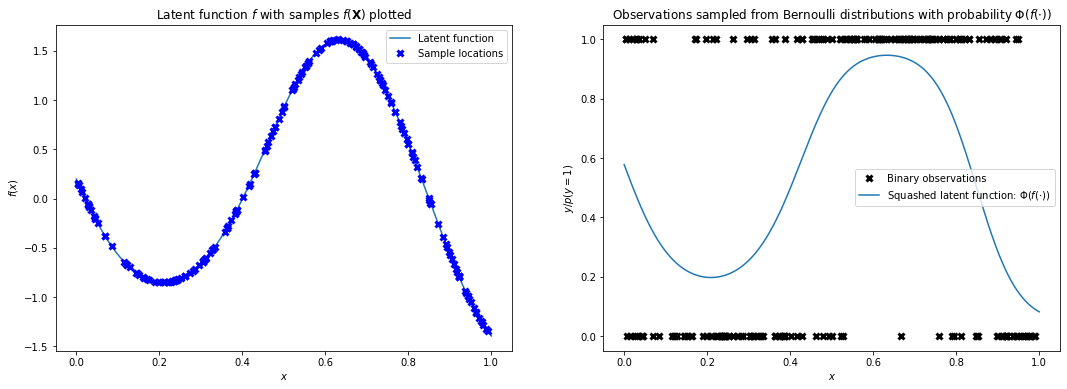

In [12]:
plt.figure(figsize=(18, 6))

# Plot latent function and sample locations
plt.subplot(121)
plt.plot(Xnew, f_true, '-', X, f, "bx", mew=3)

# Annotate plot
plt.xlabel("$x$"), plt.ylabel("$f(x)$")
plt.legend(labels=["Latent function", "Sample locations"])
plt.title("Latent function $f$ with samples $f(\mathbf{X})$ plotted")

# Plot the probit squashed f and samples from the corresponding Bernoulli distribution
plt.subplot(122)
plt.plot(X, y, 'kx', Xnew, p_s, "-", mew=3)

# Annotate plot
plt.xlabel("$x$"), plt.ylabel("$y$/$p(y=1)$")
plt.legend(labels=["Binary observations", "Squashed latent function: $\Phi(f(\cdot))$"], loc='center right')
plt.title("Observations sampled from Bernoulli distributions with probability $\Phi(f(\cdot))$");

### GP Regression with Bernoulli Likelihood

While the regression problem described here may seem _harder_ than modelling the Olympic marathon data with a Student's $t$-distribution, the steps to go through using `GPy` are just as simple.

We will need to define a kernel, a likelihood, and an inference method. Since we know the kernel used to generate the latent function above, we will reuse that (in most cases, this will be unknown). We also know the likelihood used to obtain the measurements (because we defined it to simulate them): a Bernoulli likelihood defined by taking the probit transform of the latent function. We will approximate the posterior of the latent function using these assumptions using the Laplace approximation, as with the $t$-distribution example.

Note, we could also use expectation propagation, `latent_function_inference.EP()`, but in such a simple case the choice of inference approximation method is not going to make much difference.

In [13]:
# We use the kernel used to generate f
k = GPy.kern.RBF(1, variance=1., lengthscale=0.2)

# And a Bernoulli likelihood
B_dist = GPy.likelihoods.Bernoulli(gp_link=probit)

m = GPy.core.GP( # Note that we are using the core GP model here, which allows us 
    X, y,        # .. to tailor the inference and likelihood, instead of the default
    kernel = k,  #  .. GP regression model used previously
    inference_method = GPy.inference.latent_function_inference.Laplace(), # Laplace approximation for inference
    likelihood = B_dist # Our Bernoulli likelihood as defined above
)

m.optimize()

# Preview our model
m

gp.,value,constraints,priors
rbf.variance,1.5571454099330917,+ve,
rbf.lengthscale,0.21042056990967556,+ve,


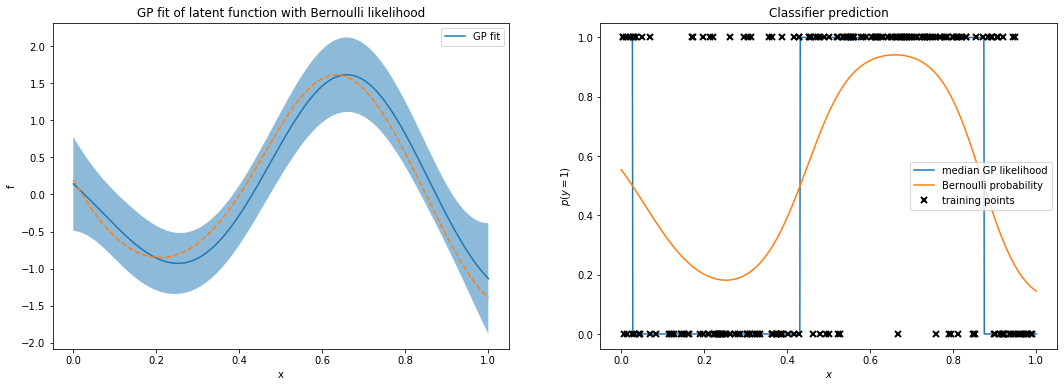

In [14]:
# We plot the latent function without the likelhood
#   This is equivalent to predict_noiseless in the previous lab
mean, Cov = m.predict(Xnew, include_likelihood=False, full_cov=True)

# We will also predict the median and 95% confidence intervals of the likelihood
quantiles = m.predict_quantiles(Xnew, quantiles=np.array([50.]), likelihood=m.likelihood)
prob, _ = m.predict(Xnew, include_likelihood=True) # Probability function for Bernoulli

# Prepare figure environment
plt.figure(figsize=(18,6))

plt.subplot(121)
# Plot the GP fit of our latent function f(X)
plot_gp(Xnew, mean, Cov)

plt.plot(Xnew, f_true, "--")
# Annotate plot
plt.title("GP fit of latent function with Bernoulli likelihood")

plt.subplot(122)
# Plot the median and mean of the predicted likelihood
plt.plot(Xnew, quantiles[0], "-", Xnew, prob, "-")
plt.plot(X, y, "kx", mew=2)

# Annotate plot
plt.xlabel("$x$"), plt.ylabel("$p(y=1)$")
plt.title("Classifier prediction");
plt.legend(labels=["median GP likelihood", "Bernoulli probability", "training points"]);

Here we have plotted the inferred latent function $f$, and on the right, the mean and median of the predicted likelihood. In the Bernoulli distribution, the mean is the probability parameter, $p_i$ of the Bernoulli distribution, and the median is defined as $1$ if $p_i > (1-p_i)$, $0.5$ if $p_i = (1-p_i)$ and $0$ otherwise. This makes it a suitable candidate for a decision boundary, as demonstrated in the above plot.

### Multiple Input Classification

We can apply the above example to a 2-D classification example. Taking the multi-input example from Lab 1, we will define our latent function, $f(x_i, x_j)$, as the product of sinusoids in the respective input dimensions $x_i$ and $x_j$ and create a classifier that evaluates an input based on whether it's greater than zero or not:

$$
    y(x_i,x_j) = \begin{cases}1 & \text{if } f(x_i,x_j) + \varepsilon > 0 \\ 0 & \text{otherwise} \end{cases},
$$

where $\varepsilon \sim \mathcal{N}(0, 1e-4)$ describes some random observation noise in our classifier. Note that this is not exactly a Bernoulli distribution, as was the case in the previous example, but we will attempt to fit it with one with our GP regression model.

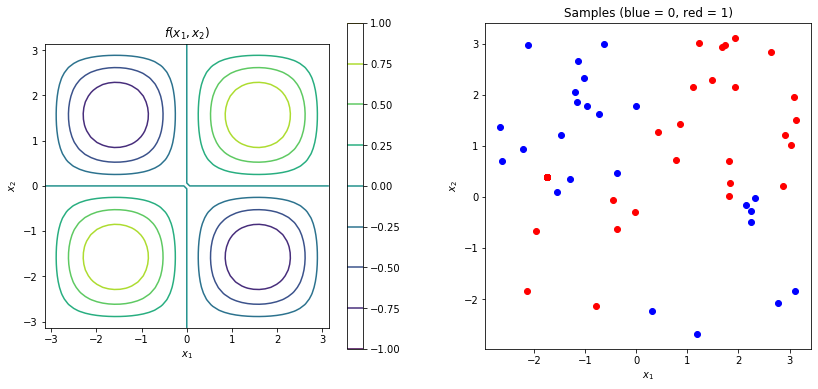

In [15]:
# Lambda function, f, the unknown function we are trying to predict
f = lambda xi,xj: np.sin(xi) * np.sin(xj)

# Our test grid
[Xi, Xj] = np.meshgrid(np.linspace(-np.pi, np.pi, 50), np.linspace(-np.pi, np.pi, 50))

# Number of samples [YOU CAN PLAY AROUND WITH THE NUMBER OF RANDOM SAMPLES TO SEE HOW THE FIT IS AFFECTED]
num_measurements = 50

# Random sample locations (2-D)
X2 = np.random.uniform(-np.pi, np.pi, (num_measurements, 2))

# Setup plot enviornment
plt.figure(figsize=(14, 6))

plt.subplot(121)
# Show true function
plt.contour(Xi, Xj, f(Xi,Xj))
# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.colorbar()
plt.title("$f(x_1,x_2)$"), plt.axis("square")

# Our observations, y = 1 if [f(x1,x2) + epsilon > 0]otherwise 0
y = np.array(f(X2[:,0], X2[:,1]) + 0.01*np.random.randn(num_measurements) > 0, dtype=np.int)[:, None]

plt.subplot(122)
# Show sample locations
plt.plot(X2[np.where(y == 0),0], X2[np.where(y == 0),1],'bo') # Plot 0 class
plt.plot(X2[np.where(y == 1),0], X2[np.where(y == 1),1],'ro') # Plot 1 class
# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$"), plt.axis("square")
plt.title("Samples (blue = 0, red = 1)");

### Exercise 2

(a) Fit a Gaussian process to the observation data for the 2-D classification example, using a Bernoulli likelihood. Try and recover the probability surface for the Bernoulli distribution over input space `Xnew2`.

_Remember from Lab 1 that we need to reshape our output into a grid the same shape as our inputs: e.g._ `mean2.reshape(Xi.shape)`

In [16]:
Xnew2 = np.vstack((Xi.ravel(), Xj.ravel())).T # Change our input grid to list of coordinates

# Put your answer here

(b) Find a decision boundary and plot it over the input space `Xnew2` along with the samples. What do you think of the decision boundary? Does it capture the rules of the classifier?

(c) As mentioned before, the mean of a Bernoulli distribution is $p$. The variance is defined by $p(1-p)$. Plot the variance of your GP likelihood fit and comment on how it might reflect the uncertainty in the predicted classifier.

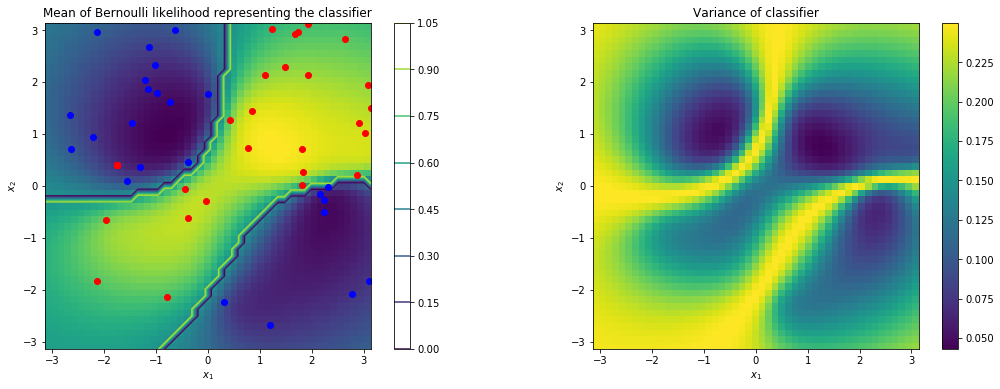

In [17]:
Xnew2 = np.vstack((Xi.ravel(), Xj.ravel())).T

# 2D isotropic RBF will do (see Lab 1)
k = GPy.kern.RBF(2, active_dims=[0, 1])

# Bernoulli likelihood
B_dist  = GPy.likelihoods.Bernoulli(gp_link=probit)

# We'll use Laplace approximation here
m = GPy.core.GP( # Note that we are using the core GP model here, which allows us 
    X2, y,        # .. to tailor the inference and likelihood, instead of the default
    kernel = k,  #  .. GP regression model used previously
    inference_method = GPy.inference.latent_function_inference.Laplace(), # Laplace approximation for inference
    likelihood = B_dist
)

m.optimize(messages=True, max_iters=200)

Xnew2 = np.vstack((Xi.ravel(), Xj.ravel())).T # Change our input grid to list of coordinates

# We plot the latent function without the likelhood
#   This is equivalent to predict_noiseless in the previous lab
mean2, Cov2 = m.predict(Xnew2, include_likelihood=False, full_cov=True)

# We will also predict the median and 95% confidence intervals of the likelihood
quantiles = m.predict_quantiles(Xnew2, quantiles=np.array([50.]), likelihood=m.likelihood)
prob, _ = m.predict(Xnew2, include_likelihood=True)

# Prepare figure environment
plt.figure(figsize=(18,6))

####
plt.subplot(121)

# # Plot the median of the predicted likelihood
plt.pcolor(Xi, Xj, prob.reshape(Xi.shape)) # (a)
plt.contour(Xi,Xj,quantiles[0].reshape(Xi.shape)) # (b)

# plt.plot(X, y, "kx", mew=2)
plt.plot(X2[np.where(y == 0),0],X2[np.where(y == 0),1],'bo')
plt.plot(X2[np.where(y == 1),0],X2[np.where(y == 1),1],'ro')

# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.axis("square")
plt.title("Mean of Bernoulli likelihood representing the classifier")
plt.colorbar();

#====
plt.subplot(122)
# We can extract the variance from our mean function estimation of the Bernoulli distribution. 
plt.pcolor(Xi, Xj, (prob*(1.-prob)).reshape(Xi.shape)) # (c)

# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("Variance of classifier")
plt.axis("square")
plt.colorbar();

> Note that our latent function f is not really possible to be replicated, because the classifier does not discriminate the nature of postive or negative f. The key thing we would like to approximate is a decision boundary in classifier space. The shape of the mean likelihood well approximates the properties of the classifier.
> 
> It is clear that the decision boundary defined by the median is a pretty good fit for the classifier, though we might use other quantiles to bound our confidence in the decision.
> 
> The variance generally corroborates our interpretation, with the greatest uncertainty appearing along the decision boundary and along the edges of the plots where there is less information. We were to extrapolate the classifier beyound the bounds of the input space, we would find the variance explodes, as in the case with standard regression.

---
## 4. Sparse Gaussian Processes

The non-parametric formulation that characterises Gaussian processes makes the cost of inference prohibitive when the number of data observations is large. The computational cost of inference is $\mathscr{O}(N^3)$, where $N$ is the number of observations, for full GP regression, as a result of matrix inversions required to calculate the posterior. In order to deal with this, an augmentation of the GP regression model called _sparse GPs_ aims to use a small set of _inducing variables_ to approximate the probability space. The driving idea is to find a posterior over the smaller set of $M (\ll N)$ inducing variables instead of over $N$ training points to reduce the computational requirements. The challenge, then, is to find the set of inducing variables and model parameters that best approximate the full GP.

In the following example, we will explicitly be working with Gaussian likelihoods again, to introduce the concept of sparse approximation in a simple setting. It is possible to extend sparse GPs to non-Gaussian likelihoods, which we will discuss at the end of this notebook.

### Full versus Sparse Gaussian Process Regression

In the following example, we will simulate some observations sampled from a GP, and compare the results of sparse and full regression.

First we will generate $N=50$ samples from a GP:

In [18]:
# This is important for reproducing the latent function
np.random.seed(40918)

# The covariance in the latent function is an RBF with l=0.2
k = GPy.kern.RBF(1, variance=1., lengthscale=0.1)

# Create a smooth GP latent function
X = np.sort(np.random.rand(50, 1), 0)
y = np.random.multivariate_normal(np.zeros(50), k.K(X,X) + 0.01*np.eye(50))[:, None]

While $N=50$ is not a _huge_ number of data, this example will show that we can get a reasonably accurate fit with only a small number of inducing variables, $M=3$. This will reduce the complexity of full GP regression, $\mathscr{O}(N^3)$, to $\mathscr{O}(NM^2)$, which is clearly a useful reduction in computational requirements &ndash; even in this basic example, we can see $450 \ll 125000$.

We make use of the `SparseGPRegression` model which, like the `GPRegression` model, has sensible defaults that we don't need to worry about for this example. The `SparseGPRegression` assumes a Gaussian likelihood and uses exact Gaussian inference. We could also define these explicitly using `core.SVGP`, which is the sparse equivalent of `core.GP` that we used above, allowing us to define the inference method, and likelihood.

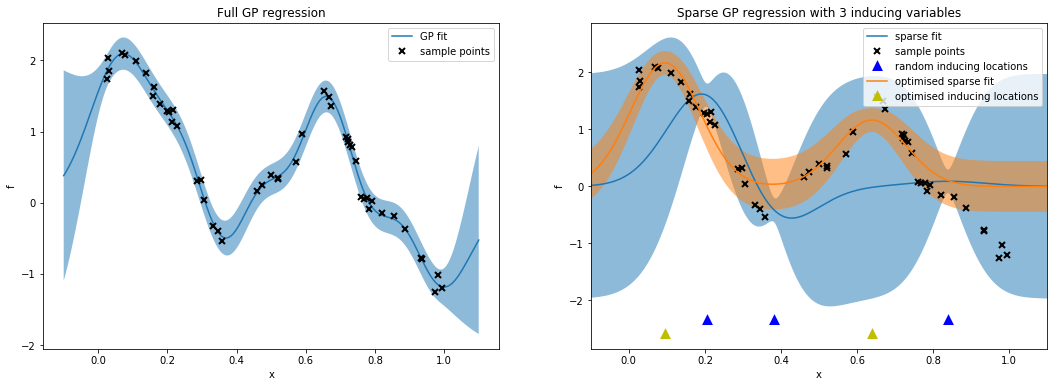

In [19]:
# Our sample space for predictions from the posterior
Xnew = np.linspace(-0.1, 1.1, 1000)[:, None]

# The covariance we used to generate the samples (assumed)
k = GPy.kern.RBF(1, variance=1., lengthscale=0.1)

# Prepare figure enviroment
plt.figure(figsize=(18, 6))

plt.subplot(121)
## First we fit with full GP regression 
m = GPy.models.GPRegression(X, y, kernel=k)
m.Gaussian_noise.variance = 0.01

# Note we don't even optimise the hyperparameters because they are known here
mean_full, Cov_full = m.predict(Xnew, full_cov=True)

# We plot our regression fit of the likelihood
plot_gp(Xnew, mean_full, Cov_full, training_points=(X, y))
plt.title("Full GP regression")


plt.subplot(122) 
## Next, we define M=3 inducing points randomly within the sample space
Z = np.random.rand(3, 1)

# We fit with sparse GP regression using randomly assigned inducing variables
m = GPy.models.SparseGPRegression(X, y, Z=Z, kernel=k)
m.Gaussian_noise.variance = 0.01
m.Gaussian_noise.fix() # We fix the Gaussian observation noise

# We will not optimise any of the hyperparameters again
mean_sparse_rand, Cov_sparse_rand = m.predict(Xnew, full_cov=True)

# Plot the posterior of the likelihood fit using a sparse GP
plot_gp(Xnew, mean_sparse_rand, Cov_sparse_rand, training_points=(X, y))
# Plot the randomly assigned inducing variables
plt.plot(Z, [plt.ylim()[0] for _ in Z], 'b^', mew=3)
         
## We are now going to optimise the model
# We will optimise the inducing point locations and the 
# .. kernel hyperparameters with respect to each other (remember the noise is fixed)
m.optimize()

# We predict the optimised sparse GP fit
mean_sparse_opt, Cov_sparse_opt = m.predict(Xnew, full_cov=True)

# We plot our new mean
plot_gp(Xnew, mean_sparse_opt, Cov_sparse_opt)
# Plot optimised inducing variable locations
plt.plot(m.Z, [plt.ylim()[0] for _ in m.Z], 'y^', mew=3)

# Annotate plot
plt.xlim((-0.1, 1.1)), plt.title("Sparse GP regression with 3 inducing variables")
plt.legend(labels=["sparse fit", "sample points", "random inducing locations", "optimised sparse fit", "optimised inducing locations"]);

With such a small number of data points, it's clearly a better option to use full Gaussian process regression here. However, our optimised sparse GP fit produces a sufficiently good fit of the data considering the small ($M=3$) number of inducing variables used. It should be clear that when we have a substantially larger number of data points $N$, using sparse GPs will provide a scalable solution when it is no longer feasible to calculate the full GP.

### A Longer Example

In the next example, we will try and use sparse GPs to approximate an unknown function for which we have a large number of (noisy) observations.

Consider the function
$$
    f(x) = \sin(2\pi x) + \sin(25\pi x) + \sin(5\pi x) + \sin(11\pi x)
$$

We have a large number of observations, $N=5000$:

$$
    \mathbf{y} = f(\mathbf{X}) + \varepsilon,
$$

and for now, we will assume a Gaussian likelihood: $\varepsilon \sim \mathcal{N}(0, \sigma^2)$

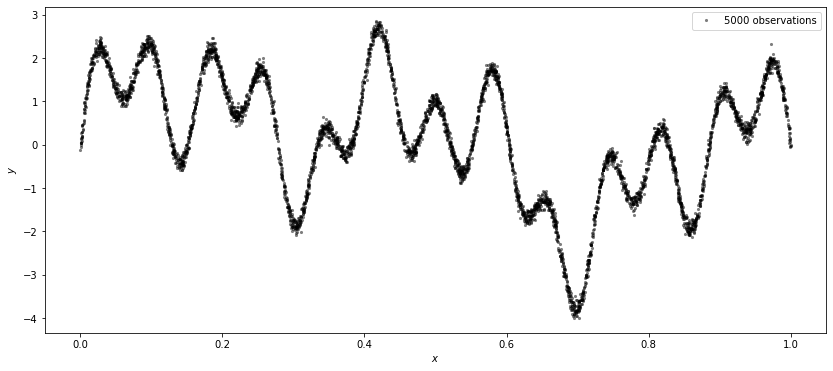

In [20]:
# True latent function
f = lambda x: sum([np.sin(w*np.pi*x) for w in [2, 25, 5, 11]])

N = 5000 # large number of observations

# Random sample locations
X = np.sort(np.random.rand(N)[:,None])
# N noisy observations of the latent function with variance 0.01
y = f(X) + 0.1*np.random.randn(N, 1)

#== Plot samples
plt.figure(figsize=(14, 6))

# Plot points (since there's a lot we make them slightly transparent)
plt.plot(X, y, 'k.', mew=0.1, alpha=0.5)

# Annotate plot
plt.xlabel("$x$"), plt.ylabel("$y$")
plt.legend(labels=["%d observations" % N]);

Clearly, if we tried to fit full GP regression to this, we would face some problems with the sheer computational resources required for matrix inversion in the Gaussian process equations.

We will use a sparse GP with a small number of inducing points, $M=20$, to try and fit the function. Given the large number of points, we will make some adjustments of the optimiser. We will cap the number of iterations to save time in the lab. These options are given to the `m.optimize()` function. We also add a small amount ($\sigma^2=10^{-6}$) of white noise to our kernel function to avoid any ill-posedness that may occur in the matrix calculations.

In [21]:
# Number of inducing variables
M = 20

# We define M inducing variables sampled uniformly throughout our input space
Z = np.linspace(0., 1., M)[:, None]

# We assume the covariance to be an RBF, and add a white noise term for numerical stability
k = GPy.kern.RBF(1, lengthscale=0.05, name="rbf") + GPy.kern.White(1, name="white")

# Define a sparse GP with Gaussian likelihood
m = GPy.core.SparseGP(
    X, y, Z,
    kernel = k,
    likelihood = GPy.likelihoods.Gaussian(),
    inference_method = GPy.inference.latent_function_inference.FITC()
)

# We define the white noise variance to 10^-6 and fix this
m.kern.white.variance = 1.e-6
m.kern.white.fix()

# We will also fix the inducing points
m.Z.fix()

# We limit the number of iterations here, to limit the maximum runtime
# .. We will also allow the optimiser to print progress messages while it is running
m.optimize(max_iters=2500, messages=1)

# Preview our sparse GP model
m

sparse_gp.,value,constraints,priors
inducing inputs,"(20, 1)",fixed,
sum.rbf.variance,1.58531528289464,+ve,
sum.rbf.lengthscale,0.05794353508203197,+ve,
sum.white.variance,1e-06,+ve fixed,
Gaussian_noise.variance,0.4891954795468102,+ve,


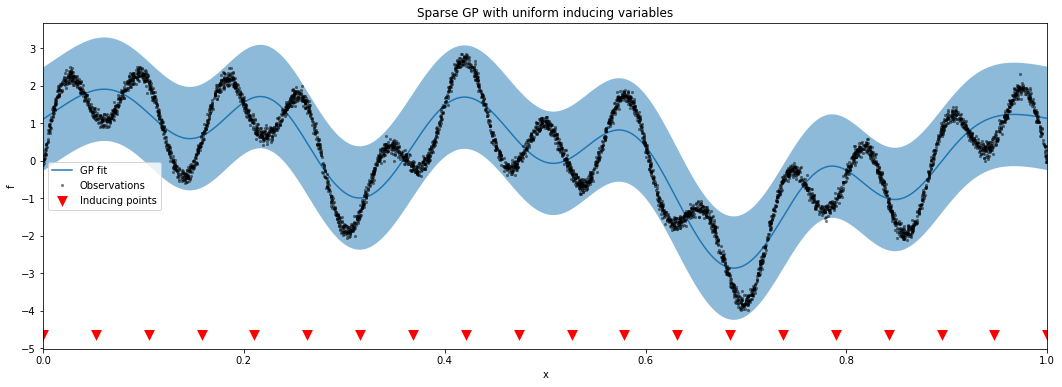

In [22]:
# We create a prediction space defined over the observation space
Xnew = np.linspace(0., 1., 2000)[:, None]

# We predict a likelihood free estimate of our latent functon
mean, Cov = m.predict(Xnew)

# Set up figure environment
plt.figure(figsize=(18, 6))

# Plot the sparse GP prediction
plot_gp(Xnew, mean, Cov)

# Plot observations
plt.plot(X, y, 'k.', mew=0.1, alpha=0.5)

# Plot inducing variable locations
plt.plot(m.Z, [plt.ylim()[0] for _ in m.Z], 'rv', mew=3)

# Annotate plot
plt.xlim((0., 1.))
plt.title("Sparse GP with uniform inducing variables")
plt.legend(labels=["GP fit", "Observations", "Inducing points"]);

### Exercise 3

(a) How do you feel about the fit? Based on what you learned in the Lab 1, what changes might you make to the kernel used?

> The fit follows the trend and is generally quite good, although it does not capture the periodicity. We could use a periodic kernel to try and capture the peaks.

(b) In the above example, we sampled the inducing variable locations uniformly. However, we can also optimise the inducing points during the fitting. Experiment with unfixing `Z` (`m.Z.unfix()`), changing the number of inducing points `M`, and see how this affects the fit. Why might this be a better or worse assumption, given the distribution of the data ?

In [23]:
M = 50

Z = np.linspace(0., 1., M)[:, None]

k = GPy.kern.RBF(1, lengthscale=0.05, name="rbf") \
     +  GPy.kern.StdPeriodic(1, period=1) * GPy.kern.RBF(1, name="rbf") \
        + GPy.kern.White(1, name="white")

m = GPy.core.SVGP(
    X, y, Z,
    kernel = k,
    likelihood = GPy.likelihoods.Gaussian()
)

m.Z.unfix()
m.kern.white.variance = 1.e-6
m.kern.white.fix()

m.optimize(max_iters=10000, messages=1)

Text(0.5, 1.0, 'Samples from posterior of sparse GP fit of latent function')

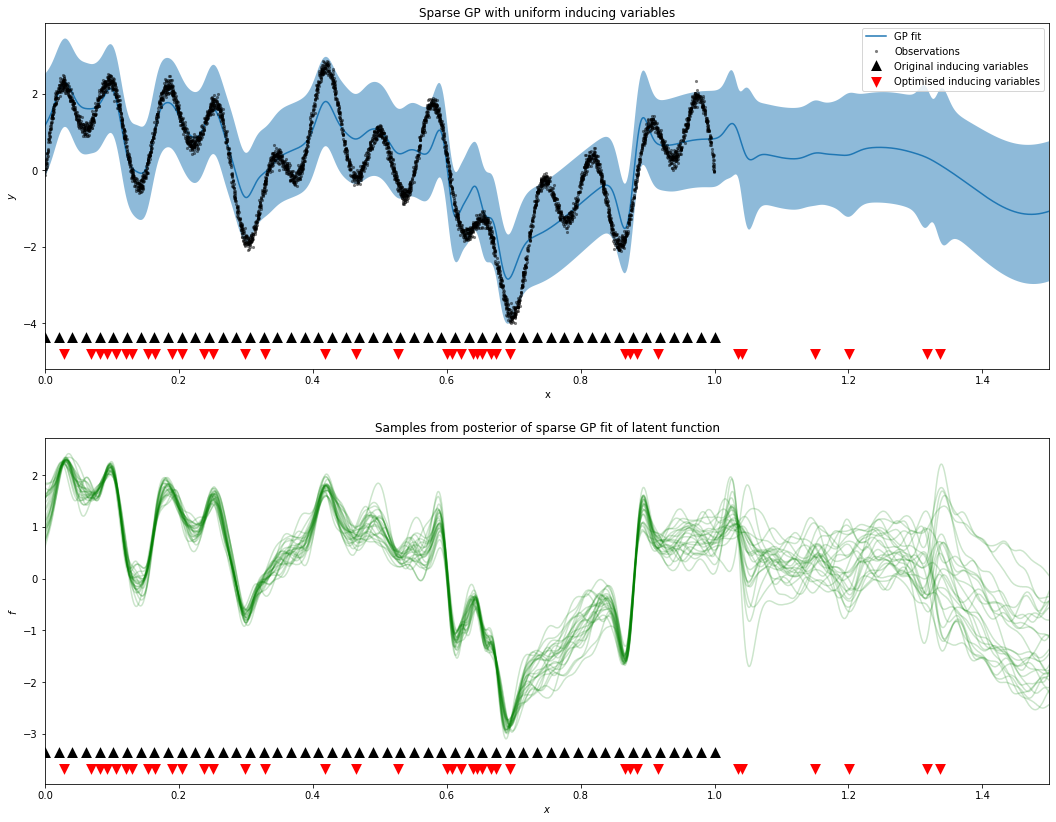

In [24]:
Xnew = np.linspace(0., 1.5, 2000)[:, None]

mean, Cov = m.predict(Xnew, full_cov=True)

plt.figure(figsize=(18, 14))

plt.subplot(211)
# Plot the sparse GP prediction
plot_gp(Xnew, mean, Cov[:,:,0])

# Plot observations
plt.plot(X, y, 'k.', mew=0.1, alpha=0.5)

# Plot inducing variable locations
plt.plot(Z, [plt.ylim()[0] for _ in Z], 'k^', mew=3)
plt.plot(m.Z, [plt.ylim()[0] for _ in m.Z], 'rv', mew=3)

# Annotate plot
plt.xlim((0., 1.5)), plt.ylabel("$y$")
plt.title("Sparse GP with uniform inducing variables")
plt.legend(labels=["GP fit", "Observations", "Original inducing variables", "Optimised inducing variables"])

## Samples
mean, Cov = m.predict_noiseless(Xnew, full_cov=True)
samples = np.random.multivariate_normal(mean[:,0], Cov[:,:,0], 25)

plt.subplot(212)
# Plot random samples drawn from GP posterior (Without likelihood noise)
for z in samples:
    plt.plot(Xnew, z, "g-", alpha=0.2)

# Plot observations
#plt.plot(X, y, 'k.', mew=0.1, alpha=0.5)

# Plot inducing variable locations
plt.plot(Z, [plt.ylim()[0] for _ in Z], 'k^', mew=3)
plt.plot(m.Z, [plt.ylim()[0] for _ in m.Z], 'rv', mew=3)

# Annotate plot
plt.xlim((0., 1.5)), plt.xlabel("$x$"), plt.ylabel("$f$")
plt.title("Samples from posterior of sparse GP fit of latent function")

## 5. Stochastic Variational Inference for GPs on Big Data with Non-Gaussian Likelihood
In the case of sparse regression of functions with a Gaussian likelihood, it is a relatively straightforward computation to calculate the posterior of a GP fit. However, for sparse approximation of non-Gaussian likelihoods, we must rely on sampling or quadrature methods to approximate the expectations. Luckily, with `GPy`, we can perform these approximations using a combination of the same routines that we have used previously.

We will first load up a dataset for a binary classification problem in 2-D. The data has a large number of observations, occuring in a complex geometry. We use the _Banana_ dataset as our classification problem. By default, the categories are labeled $-1$ and $1$, but we will map these to $[0, 1]$ so we can model the classification problem with a Bernoulli likelihood.

Data Source: _J. Alcalá-Fdez, A. Fernandez, J. Luengo, J. Derrac, S. García, L. Sánchez, F. Herrera. KEEL Data-Mining Software Tool: Data Set Repository, Integration of Algorithms and Experimental Analysis Framework. Journal of Multiple-Valued Logic and Soft Computing 17:2-3 (2011) 255-287_

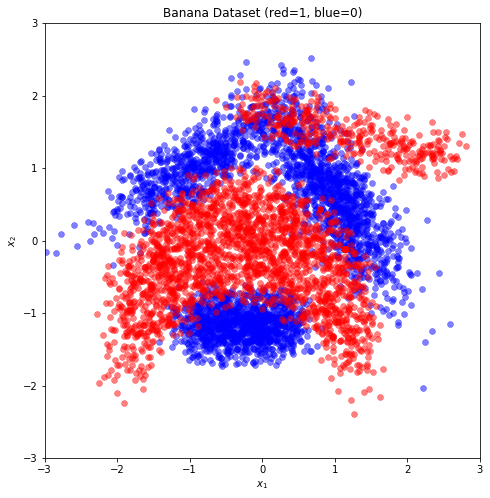

In [25]:
# Load data from file, make sure banana.csv is in the same directory as this notebook
data = np.genfromtxt('../.resources/banana.csv', delimiter=',')

# Dimension of data
D = data.shape[1]-1

# Seperate our data (input) from its corresponding label output
# .. note we have to rescale from [-1,1] to [0,1] for a Bernoulli distribution
X, y = data[:,:D], (0.5 + data[:,-1]/2)[:, None]

# We will plot our data as well
plt.figure(figsize=(8,8))

# Plot 0 class in blue
plt.plot(X[np.where(y == 0),0],X[np.where(y == 0),1], 'bo', mew=0.5, alpha=0.5)
# Plot 1 class in red
plt.plot(X[np.where(y == 1),0],X[np.where(y == 1),1], 'ro', mew=0.5, alpha=0.5)

# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("Banana Dataset (red=1, blue=0)")
plt.axis("square"), plt.xlim((-3, 3)), plt.ylim((-3, 3));

In this example, we are going to use a variational sparse GP framework, where we approximate the likelihood with a _variational distribution_. For problems with a large number data, even sparse approximations can still have trouble scaling. A recent extension, particularly for classification of large data sets with GPs is using _stochastic variational inference_ for sparse GPs$^1$.

Given a large number of data, $N$, stochastic inference utilises some randomly selected _mini-batch_ of size $B$, over which we approximate the variational evidence lower bound as a noisy subsample, with the mini-batch sizes reducing much of the computational cost.

We will use our sparse GP framework with the `core.SVGP` object in `GPy`. For now, we will just use an anisotropic `RBF` kernel with some fixed white noise, again $\sigma^2=10^{-6}$. We use a Bernoulli likelihood with a probit link function, as in our previous examples, though we alternatively could try a sigmoid, or other link functions for this problem.

Because we are using a sparse approximation, we are already making approximating the likelihood using a variational model. As a result, we don't need to specify our inference model, such as Laplace approximation. We will also use the density information to guide our inducing variable locations: we fit $k$-means and take the centroids as _fixed_ locations to save the optimiser some work. For now, we will use $M=8$ inducing variables.

The final things to consider are the size of our mini-batches, i.e. the number of samples we take from our data during each iteration, and the choice of optimiser: we want a stochastic optimiser, and in this example we will use Adadelta.

$^1$ Hensman, J., Matthews, A.G.d.G. and Ghahramani, Z., 2015. [_Scalable variational Gaussian process classification_](https://arxiv.org/abs/1411.2005)

In [26]:
from scipy.cluster.vq import kmeans

# Number of inducing points
M = 8

# Our initial inducing points, assigned with k-means
Z = 1. * kmeans(X, M)[0]

# We use a 2-D anisotropic RBF kernel here, to allow us different lengthscales in each direction
k = GPy.kern.RBF(D, active_dims=[0, 1], ARD=True) + GPy.kern.White(D, variance=1.e-6)

# Bernoulli likelihood
B_dist  = GPy.likelihoods.Bernoulli(gp_link=probit)

# size of minibatch
batchsize = 10

# Fit a sparse variational Gaussian process our data, inducing points and a Bernoulli likelihood
m = GPy.core.SVGP(
    X, y, Z,
    kernel=GPy.kern.RBF(D, active_dims=[0, 1], ARD=True) + GPy.kern.White(D, variance=1.e-6),
    likelihood=B_dist,
    batchsize=batchsize
)

# We will fix the white noise of our kernel to 10^-6
m.kern.white.fix();

# Fix the inducing inputs to the kmeans initialised locations
m.Z.fix();

#### Stochastic Optimisation

Whereas previously we have used deterministic optimisers to optimise the parameters, here we will make use of a stochastic optimiser that will take minibatches of the data. In this example, we will use `Adadelta`:

In [27]:
from climin import Adadelta

The following cell contains some utilities for showing the optimiser. We create a widget for jupyter, and create a callback function that the optimiser will execute during each iteration, until the callback returns `True`.

In [28]:
## This is a small utility for giving realtime output of the optimiser
import ipywidgets

logpy = ipywidgets.Label(align='right')
prog  = ipywidgets.FloatProgress(value=0., min=0., max=1.)
progress_widget = ipywidgets.HBox([prog, ipywidgets.Label("obj : "), logpy])

def write_out(*v):
    ''' writes progress and loss to the widget '''
    prog.value, logpy.value = v

max_iter = 2000
# callback during each optimisation step
def callback(i):
    ''' callback during each optimisation step: prints progress and loss, and exits after max_iterations'''
    write_out(i['n_iter']/max_iter, str(-m.log_likelihood()))
    if i['n_iter'] > max_iter:
        return True # when True is returned, the optimiser will stop
    return False

We can now set up and execute the optimiser to minimise the objective function of the model: the negative log-likelihood.

In [29]:
# Display the progress widget
display(progress_widget)

# Initialise optimiser with model parameters and gradients
opt = Adadelta(m.optimizer_array, m.stochastic_grad)

# Minimise negative log likelihood until callback returns True (i.e. after max_iter runs) 
_ = opt.minimize_until(callback)

# Print final model
display(m)

SVGP.,value,constraints,priors
inducing inputs,"(8, 2)",fixed,
sum.rbf.variance,0.37686257928372835,+ve,
sum.rbf.lengthscale,"(2,)",+ve,
sum.white.variance,1e-06,+ve fixed,
q_u_chol,"(36, 1)",,
q_u_mean,"(8, 1)",,


We want to look at the classifer created by our regression fit. The best way to do this is to model the probability surface of the Bernoulli likelihood. This is defined as our latent function approximated through the probit transform, and serves as a good representation of classifer. We will also plot the _median_ of the Bernoulli likelihood, as we did in the 1-D example, which gives us a good point estimate of a decision boundary.

Remember, we can calculate the variance of a Bernoulli distribution with $p(1-p)$, where $p$ is our squashed mean latent function that serves as the probability of the likelihood.

We will define a prediction space over $[-3, 3] \times [-3, 3]$:

In [30]:
Xi, Xj = np.meshgrid(np.linspace(-3., 3., 100), np.linspace(-3., 3., 100))
Xnew2 = np.vstack((Xi.ravel(), Xj.ravel())).T # Change our input grid to list of coordinates

# Predict the mean of the likelihood, which serves as our Bernoulli probability
prob, _ = m.predict(Xnew2, include_likelihood=True)
# Define a decision boundary by finding the median (the point where the probability switches between >0.5 and <0.5)
quantiles = m.predict_quantiles(Xnew2, quantiles=np.array([50.]), likelihood=m.likelihood)

We will create a utility plot tool to speed up plotting results:

In [31]:
def plot_2d_decision(Xi, Xj, prob, quantiles):
    # Create our figure environment
    plt.figure(figsize=(18,6))

    #### We plot first the probability of our Bernoulli likelihood
    plt.subplot(121)

    # Plot the mean likelihood
    plt.contourf(Xi, Xj, prob.reshape(Xi.shape))
    # Plot the median of the predicted likelihood
    plt.contour(Xi, Xj, quantiles[0].reshape(Xi.shape))

    # Plot the data points
    plt.plot(X[np.where(y == 0),0],X[np.where(y == 0),1],'bo', mew=0.5, alpha=0.2)
    plt.plot(X[np.where(y == 1),0],X[np.where(y == 1),1],'ro', mew=0.5, alpha=0.2)

    # Plot the inducing variables
    plt.plot(Z[:,0], Z[:,1],'k^')

    # Annotate plot
    plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
    plt.axis("square"), plt.xlim((-3, 3)), plt.ylim((-3, 3))
    plt.title("Mean of Bernoulli likelihood representing the classifier")
    plt.colorbar();

    #### We will also plot the variance of the classifer
    plt.subplot(122)
    # We can extract the variance from our mean function estimation of the Bernoulli distribution. 
    plt.pcolor(Xi, Xj, (prob*(1.-prob)).reshape(Xi.shape))

    # Annotate plot
    plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
    plt.title("Variance of classifier")
    plt.axis("square"), plt.xlim((-3, 3)), plt.ylim((-3, 3))
    plt.colorbar();

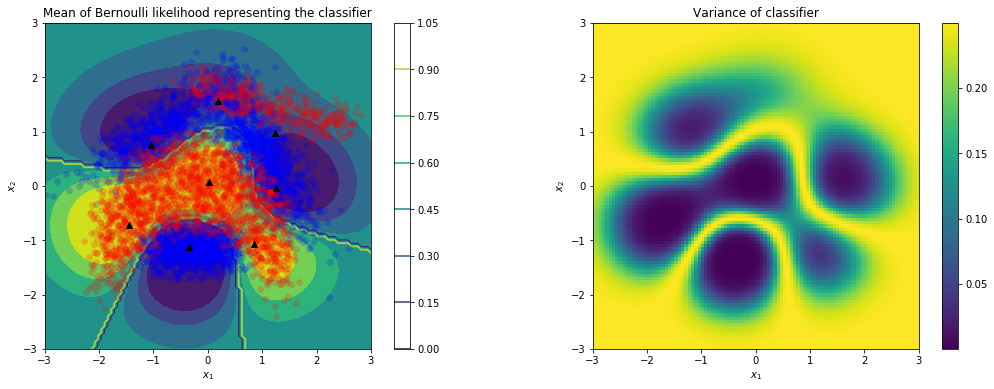

In [32]:
plot_2d_decision(Xi, Xj, prob, quantiles)

### Exercise 4

(a) In the above example, we preset the number of inducing points to $M=8$ and fixed their positions to the centroids of a $k$-means clustering. Try experimenting with using random initialisation, optimisation of inducing point locations, and changing the number of inducing points. How does this affect the accuracy of the model, and the time it takes to infer a posterior?

(b) How does the size of the minibatch affect the results ?

In [33]:
from scipy.cluster.vq import kmeans

# Number of inducing points
M = 12

# Our initial inducing points, assigned with k-means
Z = 1. * kmeans(X, M)[0]

# We use a 2-D anisotropic RBF kernel here, to allow us different lengthscales in each direction
k = GPy.kern.RBF(D, active_dims=[0, 1], ARD=True) + GPy.kern.White(D, variance=1.e-6)

# Bernoulli likelihood
B_dist  = GPy.likelihoods.Bernoulli(gp_link=probit)

# size of minibatch
batchsize = 100

# Fit a sparse variational Gaussian process our data, inducing points and a Bernoulli likelihood
m = GPy.core.SVGP(
    X, y, Z,
    kernel=GPy.kern.RBF(D, active_dims=[0, 1], ARD=True) + GPy.kern.White(D, variance=1.e-6),
    likelihood=B_dist,
    batchsize=batchsize
)

# We will fix the white noise of our kernel to 10^-6
m.kern.white.fix();

In [34]:
# Display the progress widget
display(progress_widget)

# Initialise optimiser with model parameters and gradients
opt = Adadelta(m.optimizer_array, m.stochastic_grad)

# Minimise negative log likelihood until callback returns True (i.e. after max_iter runs) 
_ = opt.minimize_until(callback)

# Print final model
display(m)

SVGP.,value,constraints,priors
inducing inputs,"(12, 2)",,
sum.rbf.variance,1.74221177767981,+ve,
sum.rbf.lengthscale,"(2,)",+ve,
sum.white.variance,1e-06,+ve fixed,
q_u_chol,"(78, 1)",,
q_u_mean,"(12, 1)",,


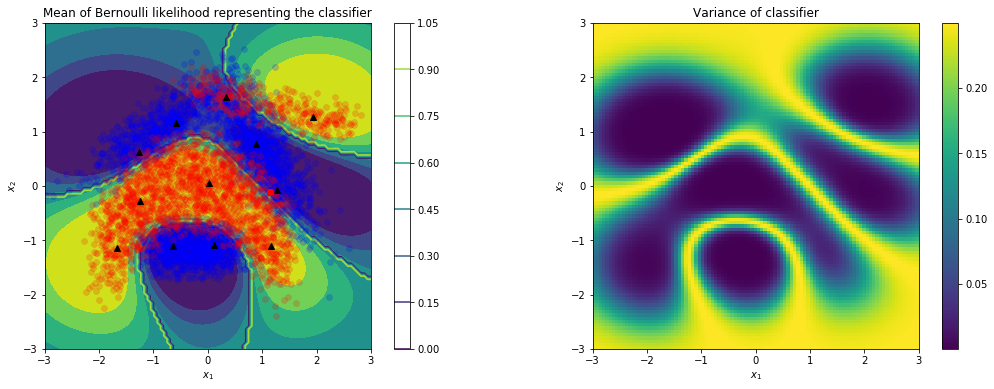

In [35]:
Xi, Xj = np.meshgrid(np.linspace(-3., 3., 100), np.linspace(-3., 3., 100))
Xnew2 = np.vstack((Xi.ravel(), Xj.ravel())).T # Change our input grid to list of coordinates

# Predict the mean of the likelihood, which serves as our Bernoulli probability
prob, _ = m.predict(Xnew2, include_likelihood=True)
# Define a decision boundary by finding the median (the point where the probability switches between >0.5 and <0.5)
quantiles = m.predict_quantiles(Xnew2, quantiles=np.array([50.]), likelihood=m.likelihood)

plot_2d_decision(Xi, Xj, prob, quantiles)

> The number of inducing variables improves our overall fit, by allowing for a more expressive regression model -- this can be observed in the underlying decision surface compared with fewer, though we only added 4 more in the above example.
> 
> The effect of minibatches is less obvious here, but a larger minibatch leads to slightly slower optimisation at each step, but for stochastic optimisers can provide more stability. This is a hyperparameter that often needs fine-tuning per problem, and depending on your optimiser, e.g. Adadelta, SGD or ADAM.

---
### Credit

This notebook was written by Wil Ward. It adapted from notebooks by [Rich Wilkinson](https://rich-d-wilkinson.github.io/) and [Neil Lawrence](http://inverseprobability.com/), and [James Hensman](http://jameshensman.github.io/). Additional writing and examples were provided by Fariba Yousefi and Juan Jose Giraldo Gutierrez.